# Análise dos dados de tumor no cerebro

---



Pacotes a serem utilizados

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import tensorflow as tf
import cv2
import cv2 as cv
import glob
import skimage.io
import shutil
import zipfile
import io
import os
from os import listdir
from PIL import Image, ImageFilter
#import imutils
import time
import scipy.ndimage
import copy
from google.colab import files
from random import shuffle
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, ZeroPadding2D, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import morphology
from skimage import measure,filters
from skimage.transform import resize
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, black_tophat, skeletonize, convex_hull_image, disk
from skimage.data import data_dir
from skimage.util import img_as_ubyte
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from PIL import Image, ImageDraw, ImageFilter

carregando a base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_list = ['/content/drive/MyDrive/cort2/no/','/content/drive/MyDrive/cort2/yes/']

In [ ]:
def load_data(dir_list):

    # load all images in a directory
    X = []
    y = []

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + filename)
            image = image / 255.
            X.append(image)
            if directory == '/content/drive/MyDrive/cort2/yes/':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
X, y = load_data(dir_list)

Number of examples is: 253
X shape is: (253, 256, 256, 3)
y shape is: (253, 1)


divisão treinamento teste e validação

In [ ]:
def split_data(X, y, test_size=0.3):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

# Modelo

In [ ]:
vgg16 = tf.keras.applications.VGG16(input_shape=(256,256,3), include_top = False, weights= 'imagenet')

In [ ]:
x = vgg16.output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(2,activation='sigmoid')(x)
tf_model=Model(inputs=vgg16.input,outputs=out)
#
tf_model.compile(optimizer=tf.keras.optimizers.Adadelta(),loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#tf_model.summary()
for layer in tf_model.layers[:20]:
    layer.trainable=False

In [ ]:
history = tf_model.fit(X_train, y_train, batch_size =32, epochs = 300, initial_epoch = 0, validation_data = (X_val, y_val),callbacks=EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15))

Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.5583 - loss: 0.8135 - val_accuracy: 0.5526 - val_loss: 0.7729
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.4600 - loss: 0.8690 - val_accuracy: 0.6053 - val_loss: 0.7459
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.5906 - loss: 0.7606 - val_accuracy: 0.5789 - val_loss: 0.7283
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.6150 - loss: 0.7399 - val_accuracy: 0.5789 - val_loss: 0.7178
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5973 - loss: 0.7246 - val_accuracy: 0.5789 - val_loss: 0.7097
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.5920 - loss: 0.7129 - val_accuracy: 0.5526 - val_loss: 0.7070
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.5501 - loss: 0.7456 - val_accuracy: 0.5526 - val_loss: 0.7027
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.6173 - loss: 0.6925 - val_accuracy: 0.5789 - va

In [ ]:
y_predt = tf_model.predict(X_test)
ytest3=np.argmax(y_test,axis=1)
y_predt= np.argmax(y_predt,axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


In [ ]:
from sklearn.metrics import accuracy_score

# y_true são as verdadeiras, y_pred são as previsões do modelo
accuracy = accuracy_score(y_predt,ytest3)
print(f'Acurácia: {accuracy}')

Acurácia: 0.8157894736842105


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(y_predt,ytest3, average='binary')
print(f'Precisão: {precision}')

Precisão: 0.92


In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(y_predt,ytest3, average='binary')
print(f'Revocação: {recall}')

Revocação: 0.8214285714285714


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_predt,ytest3, average='binary')
print(f'F1-Score: {f1}')

F1-Score: 0.8679245283018868


In [ ]:
cm1 = confusion_matrix(y_predt,ytest3);cm1 #92,101

array([[ 8,  2],
       [ 5, 23]])

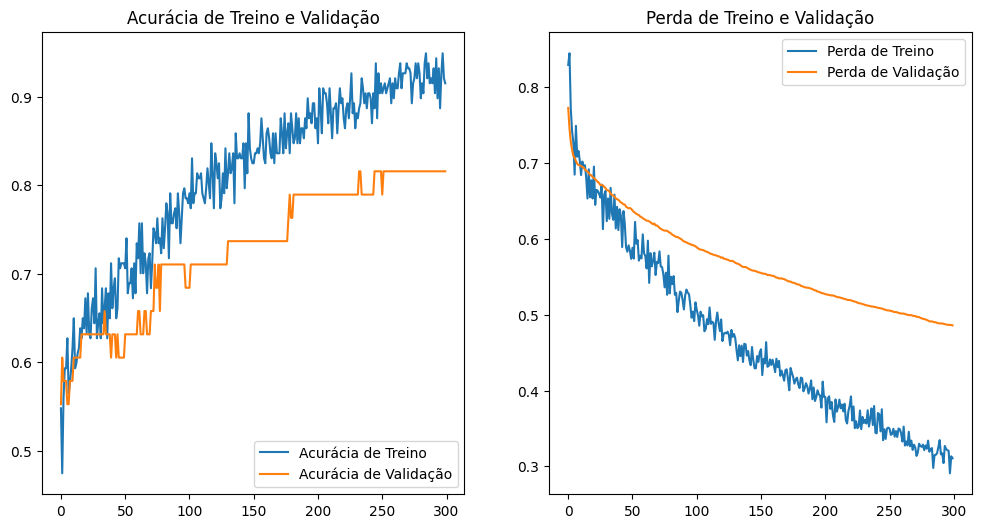

In [ ]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plotando acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treino')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treino e Validação')

    # Plotando perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treino')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Validação')

    plt.show()

# Chamando a função para plotar as curvas
plot_training_curves(history)

In [ ]:
tf_model.save('tumorceb.h5')

In [8]:
from tensorflow.keras.models import load_model

# Carregar o modelo HDF5
model_loaded = load_model('tumorceb.h5')